# Damped Sine Wave Prediction

This is the second model from Jason Brownlee's [Long Short Term Memory Networks with Python](https://machinelearningmastery.com/lstms-with-python/) book. His book has implementations using Keras, this notebook is an equivalent Pytorch implementation of the same problem. From section 7.2 of the book:

>We can generate sequences of damped sine waves of different periods and damping decay values, and withold the last few points in each series, and have the model predict them. From a model perspective, a sequence of n timesteps are fed in, then at the end of the sequence a single prediction (consisting of a vector of multiple features that we will interpret as time steps).

In [1]:
from __future__ import division, print_function
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
%matplotlib inline

## Visualize Input

Code to generate our samples. Each damped sine wave sample has a different periodicity and decay factor. We generate a sample of 5 such damped sinewaves, each with 25 timesteps, 20 of which are input timesteps and remaining 5 will be used as labels which our model must predict.

In [2]:
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * math.sin(2 * math.pi * i / period) * math.exp(-decay * i) 
            for i in range(length)]

def generate_data(num_samples, input_length, output_length):
    xs, ys = [], []
    for _ in range(num_samples):
        p = np.random.randint(low=10, high=20)
        d = np.random.uniform(0.01, 0.1)
        sequence = generate_sequence(input_length + output_length, p, d)
        xs.append(sequence[:-output_length])
        ys.append(sequence[-output_length:])
    X = np.array(xs).reshape(num_samples, input_length, 1)
    y = np.array(ys).reshape(num_samples, output_length)
    return X, y

(5, 20, 1) (5, 5)


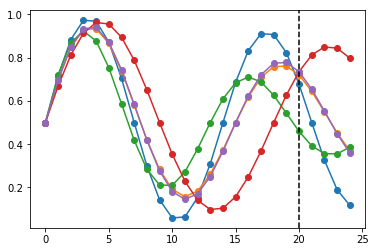

In [3]:
X, y = generate_data(5, 20, 5)
print(X.shape, y.shape)
for i in range(X.shape[0]):
    plt.plot([x for x in X[i, :, 0]] + [x for x in y[i]], marker="o")
plt.axvline(x=20, color="k", linestyle="--")
plt.show()

## Define Constants

The parameters for our model is a little different from that proposed in the book. Instead of having (10k, 0.1k, 1k) records for training, validation and test and training the model for 1 epoch, we have 1/10-th the data volume and we train for 10 epochs. We end up getting slightly better results than the model on the original data volumes.

In [4]:
NUM_TRAIN_SAMPLES = 1000
NUM_VAL_SAMPLES = 10
NUM_TEST_SAMPLES = 100

INPUT_SEQ_LEN = 50
OUTPUT_SEQ_LEN = 5

INPUT_DIM = 1
HIDDEN_DIM = 20
NUM_LAYERS = 2
OUTPUT_DIM = 5

LEARNING_RATE = 1e-3
BATCH_SIZE = 10
NUM_EPOCHS = 10

DATA_DIR = "../../data"
MODEL_FILE = os.path.join(DATA_DIR, "torch-07-dsw-pred-{:d}.model")

## Generate Training Data

In [5]:
Xtrain, ytrain = generate_data(NUM_TRAIN_SAMPLES, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN)
Xval, yval = generate_data(NUM_VAL_SAMPLES, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN)
Xtest, ytest = generate_data(NUM_TEST_SAMPLES, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(1000, 50, 1) (1000, 5) (10, 50, 1) (10, 5) (100, 50, 1) (100, 5)


## Define Network

In [6]:
class DampedSineWavePredictor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(DampedSineWavePredictor, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        if torch.cuda.is_available():
            h0 = (Variable(torch.randn(self.num_layers, x.size(0), self.hidden_dim).cuda()),
                  Variable(torch.randn(self.num_layers, x.size(0), self.hidden_dim).cuda()))
        else:
            h0 = (Variable(torch.randn(self.num_layers, x.size(0), self.hidden_dim)),
                  Variable(torch.randn(self.num_layers, x.size(0), self.hidden_dim)))
        
        out, h0 = self.lstm(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
model = DampedSineWavePredictor(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM)
if torch.cuda.is_available():
    model.cuda()
print(model)

DampedSineWavePredictor (
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (fc): Linear (20 -> 5)
)


In [8]:
loss_fn = nn.L1Loss()
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

In [9]:
history = []
for epoch in range(NUM_EPOCHS):
    num_batches = Xtrain.shape[0] // BATCH_SIZE
    
    shuffled_indices = np.random.permutation(np.arange(Xtrain.shape[0]))
    train_loss = 0.
    for bid in range(num_batches):
        Xbatch_data = Xtrain[shuffled_indices[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]]
        ybatch_data = ytrain[shuffled_indices[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        ybatch = Variable(torch.from_numpy(ybatch_data).float())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            ybatch = ybatch.cuda()
            
        # initialize gradients
        optimizer.zero_grad()
        
        # forward
        ybatch_ = model(Xbatch)
        loss = loss_fn(ybatch_, ybatch)
        
        # backward
        loss.backward()
        
        if torch.cuda.is_available():
            train_loss += loss.cpu().data[0]
        else:
            train_loss += loss.data[0]
        
        optimizer.step()
        
    # compute training loss and accuracy
    train_loss /= num_batches
    
    # compute validation loss and accuracy
    num_val_batches = Xval.shape[0] // BATCH_SIZE
    val_loss = 0.
    for bid in range(num_val_batches):
        Xbatch_data = Xval[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]
        ybatch_data = yval[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        ybatch = Variable(torch.from_numpy(ybatch_data).float())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            ybatch = ybatch.cuda()
        ybatch_ = model(Xbatch)
        loss = loss_fn(ybatch_, ybatch)
        
        if torch.cuda.is_available():
            val_loss += loss.cpu().data[0]
        else:
            val_loss += loss.data[0]
        
    val_loss /= num_val_batches
    
    torch.save(model.state_dict(), MODEL_FILE.format(epoch+1))
    print("Epoch {:2d}/{:d}: loss={:.3f}, val_loss={:.3f}"
          .format((epoch+1), NUM_EPOCHS, train_loss, val_loss))
    
    history.append((train_loss, val_loss))

Epoch  1/10: loss=0.170, val_loss=0.041
Epoch  2/10: loss=0.044, val_loss=0.040
Epoch  3/10: loss=0.043, val_loss=0.041
Epoch  4/10: loss=0.043, val_loss=0.040
Epoch  5/10: loss=0.043, val_loss=0.041
Epoch  6/10: loss=0.044, val_loss=0.040
Epoch  7/10: loss=0.042, val_loss=0.039
Epoch  8/10: loss=0.041, val_loss=0.042
Epoch  9/10: loss=0.041, val_loss=0.039
Epoch 10/10: loss=0.041, val_loss=0.039


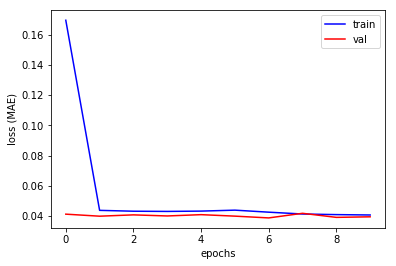

In [10]:
train_losses = [x[0] for x in history]
val_losses = [x[1] for x in history]
plt.plot(train_losses, color="b", label="train")
plt.plot(val_losses, color="r", label="val")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss (MAE)")
plt.show()

## Test Model

In [11]:
saved_model = DampedSineWavePredictor(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM)
saved_model.load_state_dict(torch.load(MODEL_FILE.format(1)))
if torch.cuda.is_available():
    saved_model.cuda()

In [12]:
ylabels, ypreds = [], []
num_test_batches = Xtest.shape[0] // BATCH_SIZE
for bid in range(num_test_batches):
    Xbatch_data = Xtest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    ybatch_data = ytest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
    ybatch = Variable(torch.from_numpy(ybatch_data).float())
    if torch.cuda.is_available():
        Xbatch = Xbatch.cuda()
        ybatch = ybatch.cuda()

    Ybatch_ = saved_model(Xbatch)
    if torch.cuda.is_available():
        ylabels.extend(ybatch.cpu().data.numpy())
        ypreds.extend(ybatch_.cpu().data.numpy())
    else:
        ylabels.extend(ybatch.data.numpy())
        ypreds.extend(ybatch_.data.numpy())

test_mae = mean_absolute_error(ypreds, ylabels)
print("MAE on test set: {:.5f}".format(test_mae))

MAE on test set: 0.05366


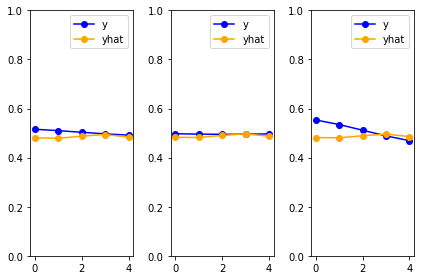

In [13]:
samples = np.random.randint(0, Xtest.shape[0], 3)
for i in range(len(samples)):
    plt.subplot(1, 3, (i+1))
    label = ylabels[samples[i]]
    pred = ypreds[samples[i]]
    xs = np.arange(len(label))
    plt.ylim([0., 1.])
    plt.plot(xs, label, color="b", marker="o", label="y")
    plt.plot(xs, pred, color="orange", marker="o", label="yhat")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [14]:
for i in range(NUM_EPOCHS):
    os.remove(MODEL_FILE.format(i + 1))